ADVANCED TOPICS IN MACHINE LEARNING

Assignment - 1

Ιπποκράτης Κοτσάνης - 131

Φιλίτσα-Ιωάννα Κουσκουβέλη - 125



----------------------------------------------------------------------------------------------------------------------------------------------------------------
PART B

# **Import the necessary libraries and modules**

In [ ]:
from numpy import mean

import pandas as pd

from pandas.api.types import CategoricalDtype
from pandas.core.frame import Frequency
from collections import Counter 

from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.ensemble import EasyEnsembleClassifier

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# **Functions**

In [ ]:
def showInfoForCols(df, colName_list):
  '''
  showInfoForCols prints some info about the columns of a dataframe, whose names 
  are included in colName_list
  '''
  for col in colName_list:
    print(col, '\n', type(df.dtypes[col]), '\n', df[col].unique())

  print(df.columns)


def changeToCatOrd_var(df, categoricalVarNames_list, months_list, days_list, ordinalTimeVarNames_list, ordinalVar_dod):
  '''
  changeToCatOrd_var pre-processes the data types of a dataframe's columns, by 
  converting them to category (and with ordered True, if the variables are 
  ordinal)
  '''
  # Categorical Variables
  for col in categoricalVarNames_list:
    df[col] = df[col].astype("category") # https://pandas.pydata.org/docs/user_guide/categorical.html

  # Ordinal Time Variables
  for col in ordinalTimeVarNames_list:
    df[col] = df[col].astype(CategoricalDtype(ordered=True))
    if 'onth' in col:
      df[col] = df[col].cat.set_categories(months_list, ordered=True)
    else:
      df[col] = df[col].cat.set_categories(days_list, ordered=True)
 
  # Ordinal simple Variables
  for col in ordinalVar_dod.keys():
    df[col] = df[col].astype(CategoricalDtype(ordered=True)) #https://pandas.pydata.org/docs/user_guide/categorical.html#sorting-and-order
    df[col] = df[col].cat.set_categories(ordinalVar_dod[col].keys(), ordered=True) # https://pandas.pydata.org/docs/user_guide/categorical.html#reordering
 
  return df


def change_catOrdToNum(df, categoricalVarNames_list, months_dict, days_dict, ordinalTimeVarNames_list, ordinalVar_dod):
  '''
  change_catOrdToNum pre-processes the data types of a dataframe's columns, by 
  converting them to dummies or "serial" integers if the variables are ordinal
  '''
  # Categorical Variables
  df = pd.get_dummies(df, columns = categoricalVarNames_list) 
  
  # Ordinal Time Variables
  for col in ordinalTimeVarNames_list:
    if 'onth' in col:
      df[col] = df[col].map(months_dict)
    else:
      df[col] = df[col].map(days_dict)

  # Ordinal simple Variables
  for col in ordinalVar_dod.keys():
    df[col] = df[col].map(ordinalVar_dod[col])
  
  return df


def create_samplingCombRand_datasets(ratio_list, X, y, overFlag=True):
  '''
  create_samplingCombRand_datasets creates a pair of X, y (re-sampled from the 
  initial) for each ratio (i.e. strategy) included in ratio_list, by applying 
  random sampling. If overFlag=True, it performs oversampling, else it performs 
  downsampling 
  '''
  combRand_datasets_lol = [] #lol: (to be) list of lists

  for ratio in ratio_list:
    # Define oversampling and undersampling strategy
    oversample = RandomOverSampler(sampling_strategy=(ratio/2) )
    undersample = RandomUnderSampler(sampling_strategy = ratio)

    # Fit and apply the transform
    if overFlag:
      X_comb, y_comb = oversample.fit_resample(X, y)
      X_comb, y_comb = undersample.fit_resample(X_comb, y_comb)
    else:
      X_comb, y_comb = undersample.fit_resample(X, y)
      X_comb, y_comb = oversample.fit_resample(X_comb, y_comb)
    
    # Save the pair of X,y as a list (of two datasets) in over_datasets_lol (which is a list)
    combRand_datasets_lol.append([X_comb, y_comb])

  for pair in combRand_datasets_lol:
    #print(type(pair[0]), pair[0].head()) # X
    #print(type(pair[1]), pair[1].head()) # y
    # summarize class distribution
    print(Counter(pair[1])) # y  

  return combRand_datasets_lol


def create_samplingRand_datasets(ratio_list, X, y, overFlag):
  '''
  create_samplingRand_datasets creates a pair of X, y (re-sampled from the 
  initial) for each ratio (i.e. strategy) included in ratio_list. If overFlag = 
  True, it first applies random oversampling and then random downsampling. If 
  not, it first applies random downsampling and then random oversampling.
  '''
  rand_datasets_lol = [] #lol: (to be) list of lists

  for ratio in ratio_list:
    # Define oversampling strategy
    if overFlag:
      sample = RandomOverSampler(sampling_strategy=ratio)
    else:
      sample = RandomUnderSampler(sampling_strategy=ratio)

    # Fit and apply the transform
    X_rand, y_rand = sample.fit_resample(X, y)
    # Save the pair of X,y as a list (of two datasets) in over_datasets_lol (which is a list)
    rand_datasets_lol.append([X_rand, y_rand])

  for pair in rand_datasets_lol:
    #print(type(pair[0]), pair[0].head()) # X
    #print(type(pair[1]), pair[1].head()) # y
    # summarize class distribution
    print(Counter(pair[1])) # y
  
  return rand_datasets_lol


def create_samplingSMOTE_datasets(ratio_list, X,y):
  '''
  create_samplingSMOTE_datasets creates a pair of X, y (re-sampled from the 
  initial) for each ratio (i.e. strategy) included in ratio_list, by applying 
  SMOTE sampling technique.
  '''
  over_datasets_lol = []
  for ratio in ratio_list:
    # Define oversampling strategy
    oversample = BorderlineSMOTE()
    
    # Fit and apply the transform
    X_over, y_over = oversample.fit_resample(X, y)
    # Save the pair of X,y as a list (of two datasets) in over_datasets_lol (which is a list)
    over_datasets_lol.append([X_over, y_over])

  for pair in over_datasets_lol:
    #print(type(pair[0]), pair[0].head()) # X
    #print(type(pair[1]), pair[1].head()) # y
    # summarize class distribution
    print(Counter(pair[1])) # y
  
  return over_datasets_lol


def create_samplingTomek_datasets(smpl_strategy_list, X, y):
  '''
  create_samplingTomek_datasets creates a pair of X, y (re-sampled from the 
  initial) for each strategy included in smpl_strategy_list, by applying Tomek 
  links (clearing) (down)sampling technique.
  '''
  under_datasets_lol = []
  for strat in smpl_strategy_list:
    # Define oversampling strategy
    print(strat)
    undersample = TomekLinks(sampling_strategy=strat)
    # Fit and apply the transform
    X_over, y_over = undersample.fit_resample(X, y)
    # Save the pair of X,y as a list (of two datasets) in over_datasets_lol (which is a list)
    under_datasets_lol.append([X_over, y_over])

  for pair in under_datasets_lol:
      #print(type(pair[0]), pair[0].head()) # X
      #print(type(pair[1]), pair[1].head()) # y
      # summarize class distribution
      print(Counter(pair[1])) # y
  
  return under_datasets_lol


def easyEnsemble(numEstim, numSplits, numRepeats, randState, scoreParam):

  # define model
  model = EasyEnsembleClassifier(n_estimators=numEstim)
  
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits = numSplits, n_repeats = numRepeats, random_state=randState)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring = scoreParam, cv=cv, n_jobs=-1)
  
  # summarize performance
  print('Mean ROC AUC: %.3f' % mean(scores))


def  randForestModel(x_train, x_test, y_train, y_test):
  # https://www.datacamp.com/tutorial/random-forests-classifier-python

  '''
  randForestModel initializes a Random Forest classifier, trains the model on the
  training set and makes predictions for the testing set. It returns the predictions. 
  '''
  rf = RandomForestClassifier()
  rf.fit(x_train, y_train)
  y_pred = rf.predict(x_test)
  return y_pred


def svmModel(x_train, x_test, y_train, y_test):
  '''
  svmModel initializes a Support Vector Machine classifier, trains the model on the
  training set and makes predictions for the testing set. It returns the predictions. 
  '''
  # https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python
  clf = SVC(kernel='linear') # Linear Kernel
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  return y_pred


def naiveBayesModel(x_train, x_test, y_train, y_test):
  '''
  naiveBayesModel initializes a Naive Bayes classifier, trains the model on the
  training set and makes predictions for the testing set. It returns the predictions. 
  '''

  # https://www.datacamp.com/tutorial/naive-bayes-scikit-learn
  clf = GaussianNB()
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  return y_pred


def evaluateModel(y_test, y_pred, confMatrixFlag=True, modelInfo=''):
  '''
  evaluateModel calculates Accuracy, F1-score, Recall, Precision metrics and 
  forms the Confusion Matrix. If confMatrixFlag=True it also plots the Confusion
  Matrix.
  '''
  y_test = y_test.map({'Yes': 1, 'No': 0}).astype(int)
  y_pred = pd.Series(y_pred).map({'Yes': 1, 'No': 0}).astype(int) 
  # https://stackoverflow.com/questions/50203106/valueerror-pos-label-1-is-not-a-valid-label-arrayneg-pos-dtype-u3

  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred, zero_division =1) 
  rec = recall_score(y_test, y_pred, zero_division =1  )
  f1 = f1_score(y_test, y_pred, zero_division =1)
  cm = confusion_matrix(y_test, y_pred)

  print(modelInfo)
  print('Accuracy: '+str(acc)+' F1-score: '+str(f1)+"\nRecall: "+str(rec)+' Precision: '+ str(prec))
  print(cm, '\n')

  if confMatrixFlag:
    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    plt.show()
    plt.clf(); plt.close()
    

  return acc, prec, rec, f1, cm


def plot_roc_auc(y_test, y_pred, title=''):
  '''
  plot_roc_auc plots a model's ROC curve
  '''
  # https://www.statology.org/plot-roc-curve-python/
  y_test = y_test.map({'Yes': 1, 'No': 0}).astype(int)
  y_pred = pd.Series(y_pred).map({'Yes': 1, 'No': 0}).astype(int) 

  fpr, tpr, _ = roc_curve(y_test,  y_pred)
  auc = roc_auc_score(y_test, y_pred)

  #create ROC curve
  
  plt.plot(fpr,tpr,label="AUC="+str(auc))
  plt.title(title)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.show()
  plt.clf(); plt.close()


def plot_multi_roc_auc(y_test, y_pred_list, title_list =[]):
  '''
  plot_multi_roc_auc plots multiple model's ROC curves in the same graph
  '''
  # https://www.statology.org/plot-multiple-roc-curves-python/
  y_test = y_test.map({'Yes': 1, 'No': 0}).astype(int)

  for  i in range(len(y_pred_list)):
    
    y_pred_list[i] = pd.Series(y_pred_list[i]).map({'Yes': 1, 'No': 0}).astype(int) 

    fpr, tpr, _ = roc_curve(y_test, y_pred_list[i])
    auc = round(roc_auc_score(y_test, y_pred_list[i]), 4)
    plt.plot(fpr,tpr,label = title_list[i]+", AUC="+str(auc))

    #add legend
    plt.legend()
  plt.show()
  plt.clf(); plt.close()



# **Explore the dataset**


In [ ]:
pd.set_option("display.max.columns", None)

# Read data
csvName = "carclaims.csv" # https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
df = pd.read_csv(csvName)

# Explore the data
print(df.head(), '\n')
print(df.dtypes, '\n')
#print(df.info())

# Define the target variable
targVarName = 'FraudFound' 
# Absolute frequency of each of the dataset's two classes
absFreq_yVal = df[targVarName].value_counts()
# Relative frequency of each of the dataset's two classes
relFreq_yVal = df[targVarName].value_counts(normalize=True)*100 # https://medium.com/@ooemma83/how-to-find-unique-values-and-their-percentage-distributions-using-value-counts-in-python-f43628660e7

print(absFreq_yVal, relFreq_yVal)

showInfoForCols(df, df.columns)

  Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  Age          Fault  \
0          Jan                   1  Female        Single   21  Policy Holder   
1          Jan                   4    Male        Single   34  Policy Holder   
2          Nov                   2    Male       Married   47  Policy Holder   
3          Jul                   1    Male       Married   65    Third Party   
4          Feb                   2  Female        Single   27    Third Party   

          PolicyType VehicleCategory      VehiclePrice  PolicyNumber  \
0  Sport

In [ ]:
#'''
# Read data
csvName = "carclaims.csv" # https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
df = pd.read_csv(csvName)
#'''

# Remove 'PolicyNumber' column which is an id column and Make column which is a brand column 
df.drop(['PolicyNumber', 'Make'], axis=1, inplace = True)

# Remove rows which have either in 'DayOfWeekClaimed' or in 'MonthClaimed' column '0' value
df.drop(df[ (df['DayOfWeekClaimed'] == '0') | (df['MonthClaimed'] == '0')].index, inplace = True) # https://sparkbyexamples.com/pandas/pandas-drop-rows-with-condition/

# Categorical Variables
categoricalVarNames_list = [ 'AccidentArea', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'BasePolicy']

# Ordinal Time Variables
ordinalTimeVarNames_list = ['Month', 'DayOfWeek',  'DayOfWeekClaimed', 'MonthClaimed']

months_dict = {'Jan':0, 'Feb':1,  'Mar':2, 'Apr':3, 'May':4, 'Jun':5, 'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11}
days_dict = {'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6}

# Ordinal simple Variables
ordinalVar_dod = {'VehiclePrice': {'less than 20,000':0,'20,000 to 29,000':1, '30,000 to 39,000':2, '40,000 to 59,000':3, '60,000 to 69,000':4, 'more than 69,000':5}, 
                  'Days:Policy-Accident': {'none':0,'1 to 7':1, '8 to 15':2, '15 to 30':3, 'more than 30':4 },  
                  'Days:Policy-Claim': {'8 to 15':0, '15 to 30':1, 'more than 30':2}, 'PastNumberOfClaims': {'none':0, '1':1, '2 to 4':2, 'more than 4':3}, 
                  'AgeOfVehicle': { 'new':0, '2 years':1, '3 years':2, '4 years':3, '5 years':4, '6 years':5, '7 years':6, 'more than 7':7}, 
                  'AgeOfPolicyHolder': {'16 to 17':0, '18 to 20':1, '21 to 25':2, '26 to 30':3, '31 to 35':4, '36 to 40':5, '41 to 50':6, '51 to 65':7, 'over 65':8}, 
                  'NumberOfSuppliments' : {'none':0, '1 to 2':1, '3 to 5':2, 'more than 5':3 }, 
                  'AddressChange-Claim': {'no change':0, 'under 6 months':1,'1 year':2,'2 to 3 years':3,'4 to 8 years':4 }, 
                  'NumberOfCars': {'1 vehicle':0, '2 vehicles':1, '3 to 4':2, '5 to 8':3, 'more than 8':4}  }        

'''
df = changeToCatOrd_var(df, categoricalVarNames_list, months_dict.keys(), days_dict.keys(), ordinalTimeVarNames_list, ordinalVar_dod)
showInfoForCols(df, ordinalVar_dod.keys())
'''
df = change_catOrdToNum(df, categoricalVarNames_list, months_dict, days_dict, ordinalTimeVarNames_list, ordinalVar_dod)
showInfoForCols(df, df.columns)
#'''

Month 
 <class 'numpy.dtype[int64]'> 
 [11  0  9  5  1 10  3  2  7  6  4  8]
WeekOfMonth 
 <class 'numpy.dtype[int64]'> 
 [5 3 2 4 1]
DayOfWeek 
 <class 'numpy.dtype[int64]'> 
 [3 5 6 1 2 0 4]
DayOfWeekClaimed 
 <class 'numpy.dtype[int64]'> 
 [2 1 4 5 3 6 0]
MonthClaimed 
 <class 'numpy.dtype[int64]'> 
 [ 0 10  6  1  2 11  3  7  4  5  8  9]
WeekOfMonthClaimed 
 <class 'numpy.dtype[int64]'> 
 [1 4 2 3 5]
Age 
 <class 'numpy.dtype[int64]'> 
 [21 34 47 65 27 20 36  0 30 42 71 52 28 61 38 41 32 40 63 31 45 60 39 55
 35 44 72 29 37 59 49 50 26 48 64 33 74 23 25 56 16 68 18 51 22 53 46 43
 57 54 69 67 19 78 77 75 80 58 73 24 76 62 79 70 17 66]
VehiclePrice 
 <class 'numpy.dtype[int64]'> 
 [5 1 2 0 3 4]
RepNumber 
 <class 'numpy.dtype[int64]'> 
 [12 15  7  4  3 14  1 13 11 16  6  2  8  5  9 10]
Deductible 
 <class 'numpy.dtype[int64]'> 
 [300 400 500 700]
DriverRating 
 <class 'numpy.dtype[int64]'> 
 [1 4 3 2]
Days:Policy-Accident 
 <class 'numpy.dtype[int64]'> 
 [4 3 0 1 2]
Days:Policy-Claim

# **Split X, y**

In [ ]:
'''
df_head = df.head(2500)
#relFreq_yVal = df_head[targVarName].value_counts(normalize=True)*100
#print(relFreq_yVal)

# Split independent variables from dependent variable
y = df_head[targVarName] #; print( y.head())
X = df_head.drop(targVarName, axis=1) #; print(X.head())

showInfoForCols(X, X.columns)
print(type(y.dtype))
'''

# Split independent variables from dependent variable
y = df[targVarName] #; print( y.head())
X = df.drop(targVarName, axis=1) #; print(X.head())
#'''

# **Sampling**

**Random Oversampling**

Create a dataset from the initial, using an oversampling technique. More specifically, random oversampling can be implemented, in Python, using the RandomOverSampler class. 

**Random Undersampling**

Create a dataset from the initial, using an undersampling technique. More specifically, random undersampling technique can be implemented, in Python, using the RandomUnderSampler imbalanced-learn class.

**Combination of Random Oversampling & Random Undersampling**

Create a dataset from the initial, using a combination of oversampling  and undersampling techniques.

A modest amount of oversampling could be applied to the minority class to improve the bias towards these examples, along with a modest amount of undersampling to the majority class to reduce the bias on that class.

In this case, oversampling will be firstly applied to increase the ratio minorityClass/majorityClass (by duplicating examples from the minority class) and then undersampling will be applied to further improve the ratio (by deleting examples from the majority class).

---


Both in Random Oversampling and in Random Undersampling the sampling_strategy parameter is to be defined as float, str, dict or callable (default=’auto’). When float, it corresponds to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling.


---

**Useful links**:

https://imbalanced--learn-org.translate.goog/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html?_x_tr_sl=en&_x_tr_tl=el&_x_tr_hl=el&_x_tr_pto=sc

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html


https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

In [ ]:
min_maj_ratio_list = [0.25, 0.5, 0.75]

overRand_datasets_lol = create_samplingRand_datasets(min_maj_ratio_list, X, y, True)
underRand_datasets_lol = create_samplingRand_datasets(min_maj_ratio_list, X, y, False)
combRand_datasets_lol = create_samplingCombRand_datasets(min_maj_ratio_list, X, y)



Counter({'No': 14496, 'Yes': 3624})
Counter({'No': 14496, 'Yes': 7248})
Counter({'No': 14496, 'Yes': 10872})
Counter({'No': 3692, 'Yes': 923})
Counter({'No': 1846, 'Yes': 923})
Counter({'No': 1230, 'Yes': 923})
Counter({'No': 7248, 'Yes': 1812})
Counter({'No': 7248, 'Yes': 3624})
Counter({'No': 7248, 'Yes': 5436})


**SMOTE Oversampling**

Create a dataset from the initial, using an oversampling technique. More specifically, synthesizing new examples (hence oversampling) can be implemented, in Python, using the BorderlineSMOTE class. 

The sampling_strategy parameter is to be defined as float, str, dict or callable (default=’auto’). When float, it corresponds to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling.

**Tomek links Undersampling**

Create a dataset from the initial, by "cleaning" the data with the Tomek links ,method. More specifically, select examples from the majority class to delete (hence undersampling) can be implemented, in Python, using the TomekLinks imbalanced-learn class.

The parameter sampling_strategy is to be defined as str, list or callable. When str it specifies the class targeted by the resampling (the number of samples will not be equal in each). Possible choices are:

'majority': resample only the majority class;

'auto', 'not minority': resample all classes but the minority class;

'not majority': resample all classes but the majority class;

'all': resample all classes;


**Useful links**:

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.TomekLinks.html

https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/

In [ ]:
overSMOTE_datasets_lol = create_samplingSMOTE_datasets(min_maj_ratio_list, X,y)

underTomek_datasets_lol = create_samplingTomek_datasets(['majority'], X, y)

# https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/

Counter({'No': 14496, 'Yes': 14496})
Counter({'No': 14496, 'Yes': 14496})
Counter({'No': 14496, 'Yes': 14496})
majority
Counter({'No': 14155, 'Yes': 923})


Στο αρχικό dataset, προκειμένου να επιτευχθεί μία καλύτερη ισορροπία μεταξύ των δύο κλάσεων της μεταβλητής στόχου, εφαρμόστηκαν οι ακόλουθες τεχνικές:

τυχαία υπερδειγματοληψία, με αναλογία minority class/majority class = 0,25

τυχαία υπερδειγματοληψία, με αναλογία minority class/majority class = 0,5 

τυχαία υπερδειγματοληψία, με αναλογία minority class/majority class = 0,75
 
τυχαία υποδειγματοληψία, με αναλογία minority class/majority class = 0,25 


τυχαία υποδειγματοληψία, με αναλογία minority class/majority class = 0,5 

τυχαία υποδειγματοληψία, με αναλογία minority class/majority class = 0,75

τυχαία υπερδειγματοληψία, με αναλογία minority class/majority class = 0,125 και ακολούθως τυχαία υποδειγματοληψία, με αναλογία minority class/majority class = 0,25


τυχαία υπερδειγματοληψία, με αναλογία minority class/majority class = 0,25 και ακολούθως τυχαία υποδειγματοληψία, με αναλογία minority class/majority class = 0,5


τυχαία υπερδειγματοληψία, με αναλογία minority class/majority class = 0,375 και ακολούθως τυχαία υποδειγματοληψία, με αναλογία minority class/majority class = 0,75


υπερδειγματοληψία με borderline  SMOTE (κατασκευή συνθετικών δεδομένων), με αναλογία minority class/majority class = 0,25


υπερδειγματοληψία με borderline  SMOTE (κατασκευή συνθετικών δεδομένων), με αναλογία minority class/majority class = 0,5 

υπερδειγματοληψία με borderline  SMOTE (κατασκευή συνθετικών δεδομένων), με αναλογία minority class/majority class = 0,75


υποδειγματοληψία με καθαρισμό δεδομένων


Από την εφαρμογή καθεμιάς από αυτές τις τεχνικές προέκυψε ένα “νέο” σύνολο δεδομένων (εκτός από το αρχικό). Κάθε ένα από αυτά τα σύνολα δεδομένων, καθώς και το αρχικό, χωρίστηκε σε training set και testing sets. Με κάθε μία από αυτές τις “πλειάδες” training και testing set εκπαιδεύτηκε και αξιολογήθηκε ένα μοντέλο Random Forest, Linear SVM και Naive Bayes αντίστοιχα. 


RF, total: Counter({'No': 14496, 'Yes': 923})
base
Accuracy: 0.9413748378728923 F1-score: 0.008771929824561405
Recall: 0.0044444444444444444 Precision: 0.3333333333333333
[[3628    2]
 [ 224    1]] 



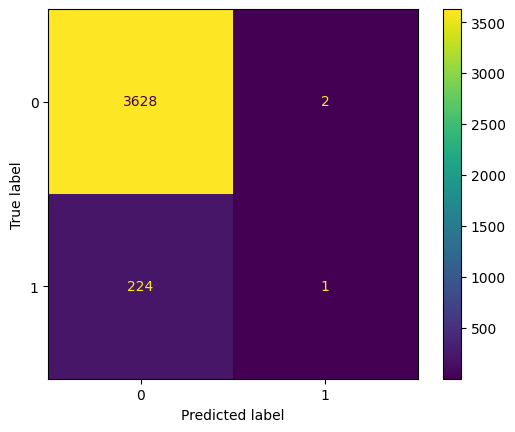

SVM, total: Counter({'No': 14496, 'Yes': 923})
base
Accuracy: 0.9416342412451362 F1-score: 0.0
Recall: 0.0 Precision: 1.0
[[3630    0]
 [ 225    0]] 



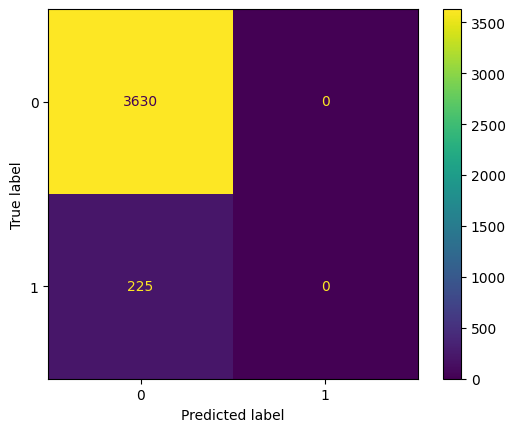

NB, total: Counter({'No': 14496, 'Yes': 923})
base
Accuracy: 0.6116731517509728 F1-score: 0.21581980094290204
Recall: 0.9155555555555556 Precision: 0.12232779097387174
[[2152 1478]
 [  19  206]] 



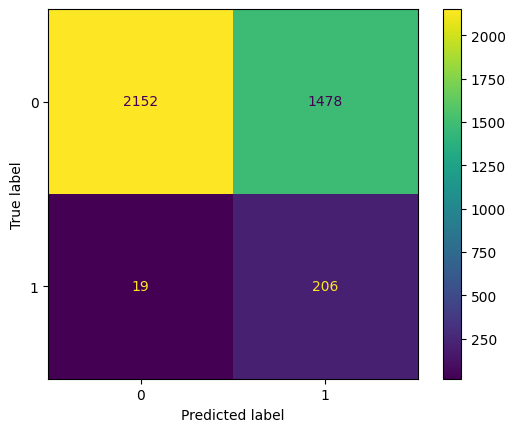

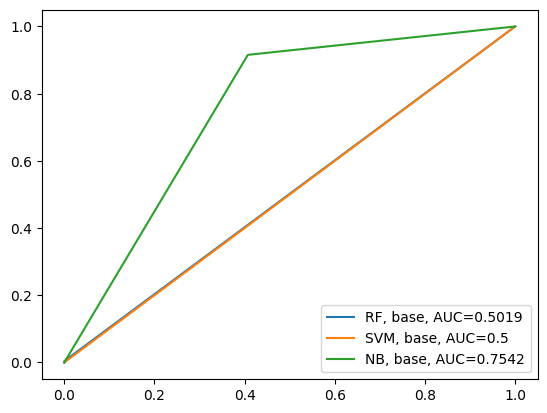

RF, total: Counter({'No': 14496, 'Yes': 3624})
over, rand, 0.25
Accuracy: 0.98719646799117 F1-score: 0.967305524239008
Recall: 0.9512195121951219 Precision: 0.9839449541284404
[[3614   14]
 [  44  858]] 



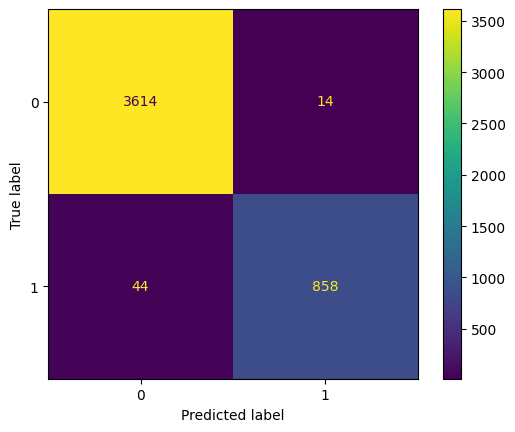

SVM, total: Counter({'No': 14496, 'Yes': 3624})
over, rand, 0.25
Accuracy: 0.8008830022075055 F1-score: 0.0
Recall: 0.0 Precision: 1.0
[[3628    0]
 [ 902    0]] 



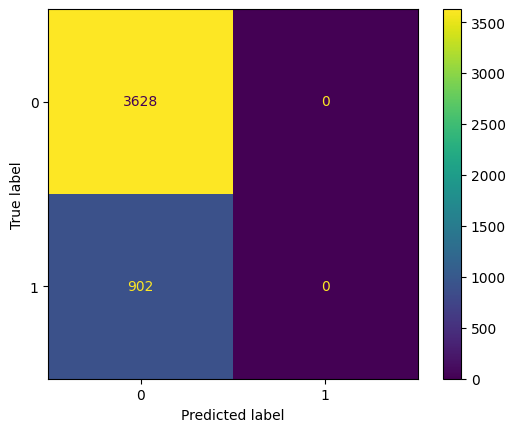

NB, total: Counter({'No': 14496, 'Yes': 3624})
over, rand, 0.25
Accuracy: 0.6501103752759382 F1-score: 0.5082221532733477
Recall: 0.9079822616407982 Precision: 0.35286514433433863
[[2126 1502]
 [  83  819]] 



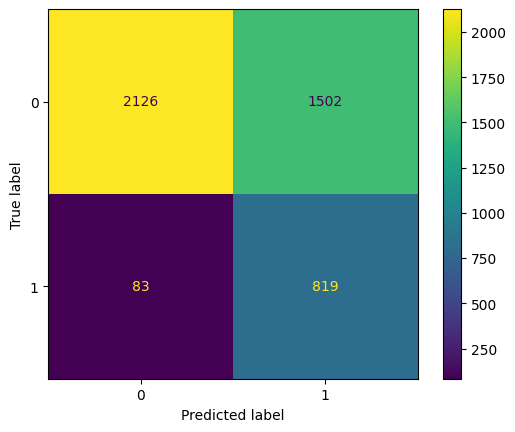

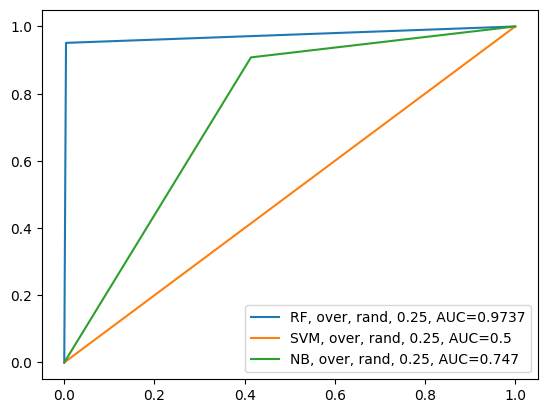

RF, total: Counter({'No': 14496, 'Yes': 7248})
over, rand, 0.5
Accuracy: 0.996504782928624 F1-score: 0.9946882862734134
Recall: 1.0 Precision: 0.9894327030033371
[[3638   19]
 [   0 1779]] 



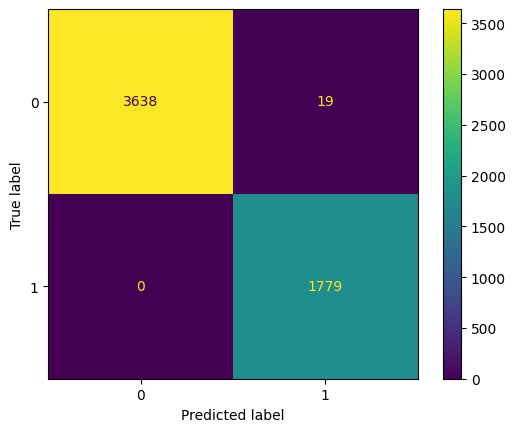

SVM, total: Counter({'No': 14496, 'Yes': 7248})
over, rand, 0.5
Accuracy: 0.7308682855040471 F1-score: 0.5586726998491705
Recall: 0.5205171444631815 Precision: 0.6028645833333334
[[3047  610]
 [ 853  926]] 



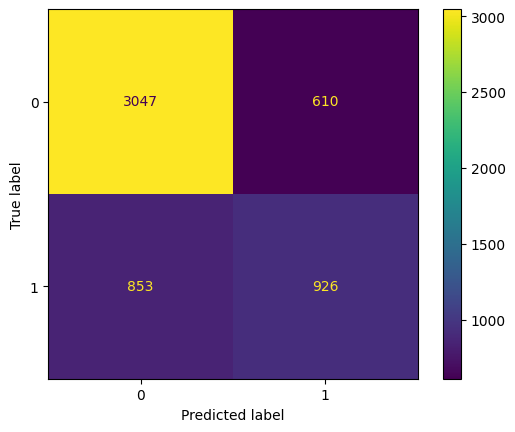

NB, total: Counter({'No': 14496, 'Yes': 7248})
over, rand, 0.5
Accuracy: 0.6927888153053716 F1-score: 0.6608448415922015
Recall: 0.9145587408656549 Precision: 0.5173290937996821
[[2139 1518]
 [ 152 1627]] 



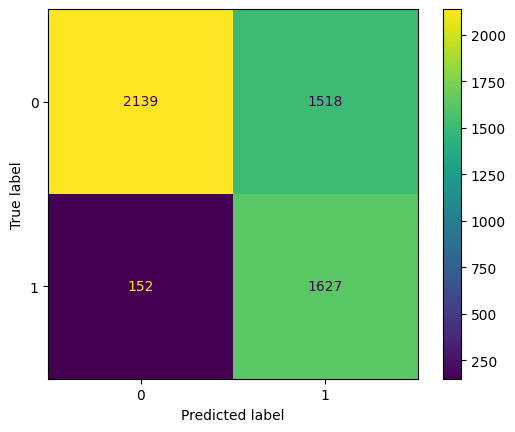



RF, total: Counter({'No': 14496, 'Yes': 10872})
over, rand, 0.75
Accuracy: 0.9971617786187322 F1-score: 0.9967426710097721
Recall: 1.0 Precision: 0.9935064935064936
[[3570   18]
 [   0 2754]] 



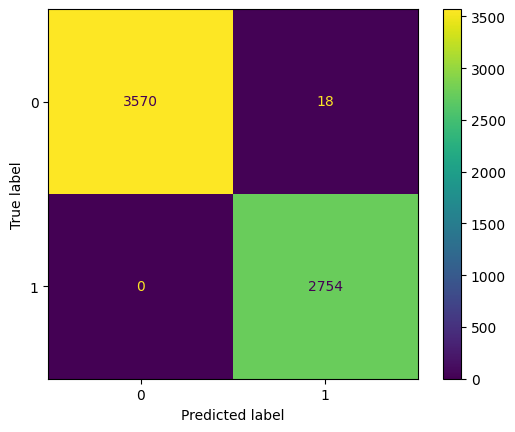

SVM, total: Counter({'No': 14496, 'Yes': 10872})
over, rand, 0.75
Accuracy: 0.7292652160201829 F1-score: 0.7410646961242648
Recall: 0.8921568627450981 Precision: 0.6337374258447253
[[2168 1420]
 [ 297 2457]] 



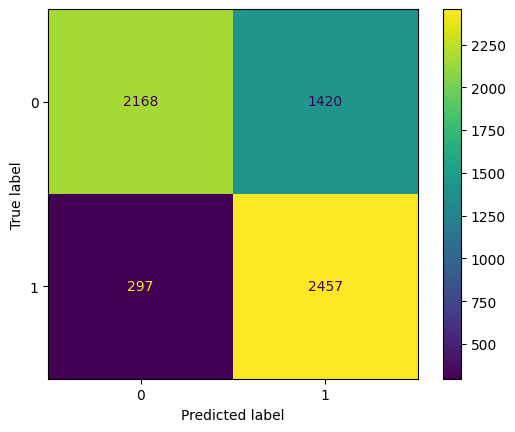

NB, total: Counter({'No': 14496, 'Yes': 10872})
over, rand, 0.75
Accuracy: 0.7235887732576475 F1-score: 0.7369842460615154
Recall: 0.8917937545388526 Precision: 0.6279723855791358
[[2133 1455]
 [ 298 2456]] 



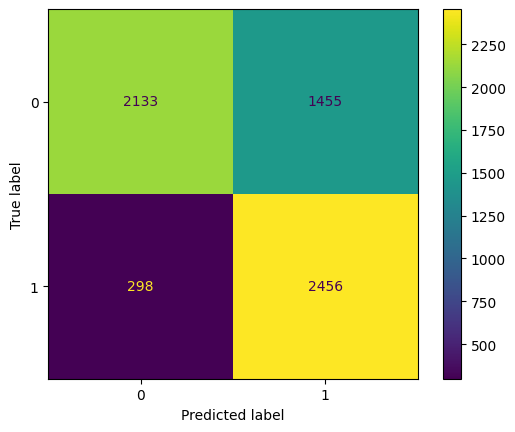



RF, total: Counter({'No': 3692, 'Yes': 923})
under, rand, 0.25
Accuracy: 0.8214904679376083 F1-score: 0.31788079470198677
Recall: 0.22748815165876776 Precision: 0.5274725274725275
[[900  43]
 [163  48]] 



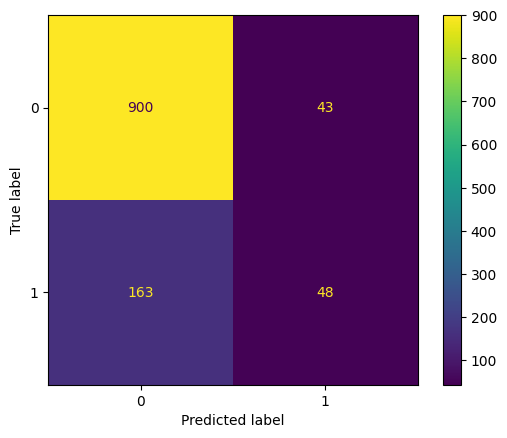

SVM, total: Counter({'No': 3692, 'Yes': 923})
under, rand, 0.25
Accuracy: 0.817157712305026 F1-score: 0.0
Recall: 0.0 Precision: 1.0
[[943   0]
 [211   0]] 



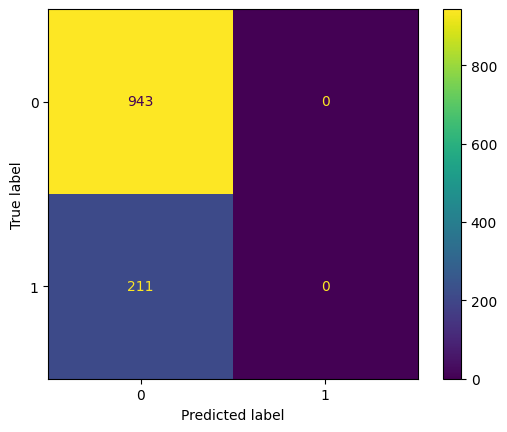

NB, total: Counter({'No': 3692, 'Yes': 923})
under, rand, 0.25
Accuracy: 0.6421143847487002 F1-score: 0.4657179818887452
Recall: 0.8530805687203792 Precision: 0.3202846975088968
[[561 382]
 [ 31 180]] 



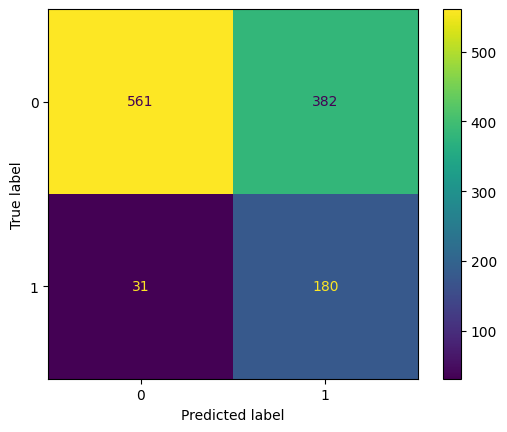

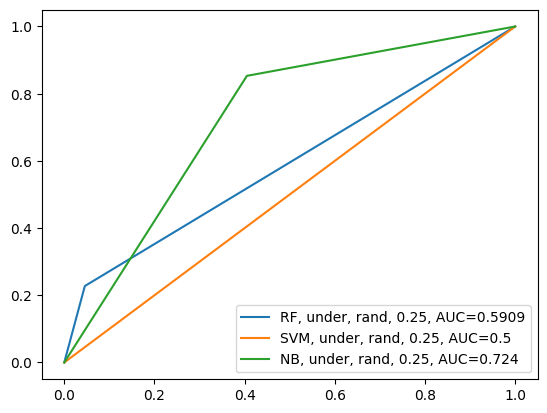

RF, total: Counter({'No': 1846, 'Yes': 923})
under, rand, 0.5
Accuracy: 0.733044733044733 F1-score: 0.6105263157894736
Recall: 0.5942622950819673 Precision: 0.6277056277056277
[[363  86]
 [ 99 145]] 



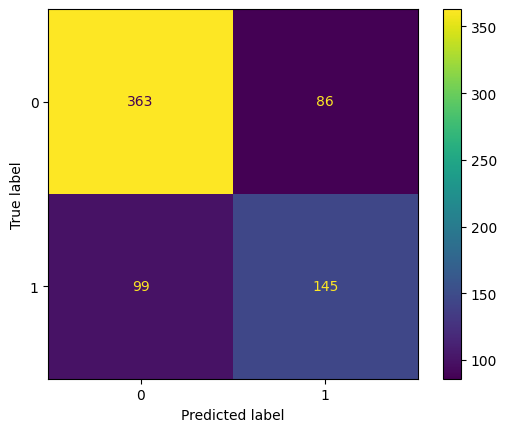

SVM, total: Counter({'No': 1846, 'Yes': 923})
under, rand, 0.5
Accuracy: 0.7171717171717171 F1-score: 0.5663716814159292
Recall: 0.5245901639344263 Precision: 0.6153846153846154
[[369  80]
 [116 128]] 



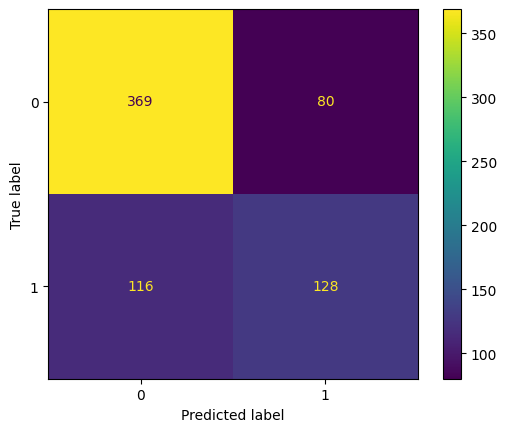

NB, total: Counter({'No': 1846, 'Yes': 923})
under, rand, 0.5
Accuracy: 0.683982683982684 F1-score: 0.6635944700460829
Recall: 0.8852459016393442 Precision: 0.5307125307125307
[[258 191]
 [ 28 216]] 



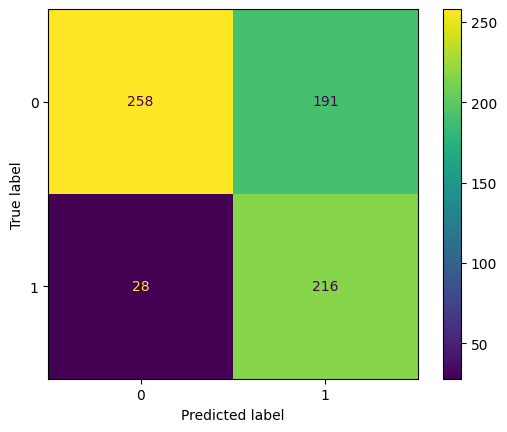



RF, total: Counter({'No': 1230, 'Yes': 923})
under, rand, 0.75
Accuracy: 0.7198515769944341 F1-score: 0.7079303675048355
Recall: 0.7204724409448819 Precision: 0.6958174904942965
[[205  80]
 [ 71 183]] 



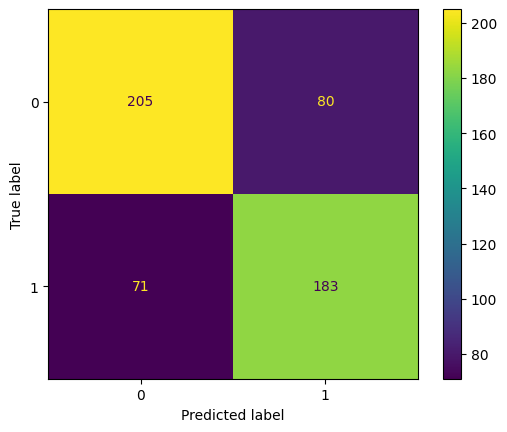

SVM, total: Counter({'No': 1230, 'Yes': 923})
under, rand, 0.75
Accuracy: 0.7272727272727273 F1-score: 0.7570247933884298
Recall: 0.9015748031496063 Precision: 0.6524216524216524
[[163 122]
 [ 25 229]] 



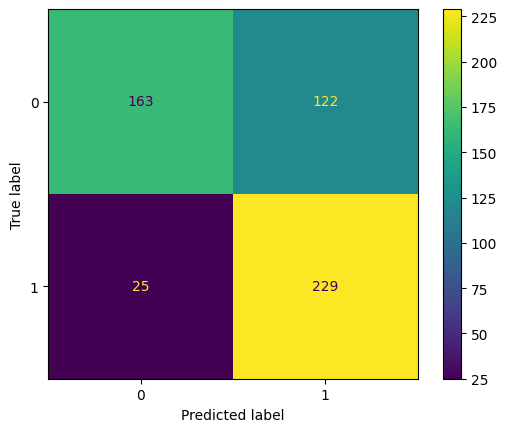

NB, total: Counter({'No': 1230, 'Yes': 923})
under, rand, 0.75
Accuracy: 0.7161410018552876 F1-score: 0.748768472906404
Recall: 0.8976377952755905 Precision: 0.6422535211267606
[[158 127]
 [ 26 228]] 



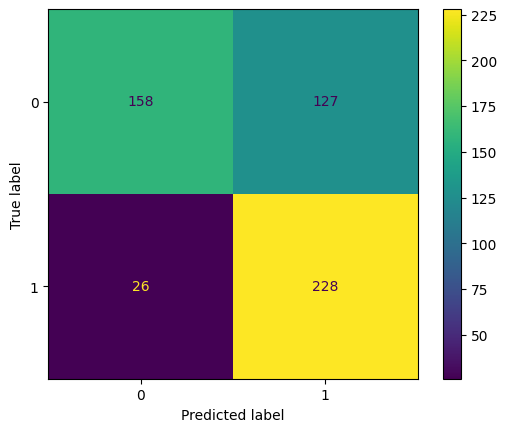



RF, total: Counter({'No': 7248, 'Yes': 1812})
over, rand, 0.125 and under, rand, 0.25
Accuracy: 0.9452538631346579 F1-score: 0.8469135802469134
Recall: 0.765625 Precision: 0.9475138121546961
[[1798   19]
 [ 105  343]] 



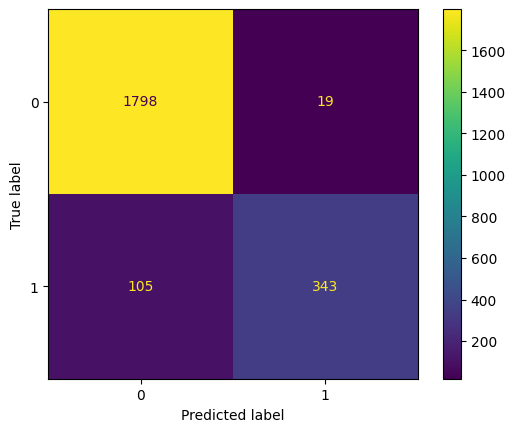

SVM, total: Counter({'No': 7248, 'Yes': 1812})
over, rand, 0.125 and under, rand, 0.25
Accuracy: 0.8022075055187637 F1-score: 0.0
Recall: 0.0 Precision: 1.0
[[1817    0]
 [ 448    0]] 



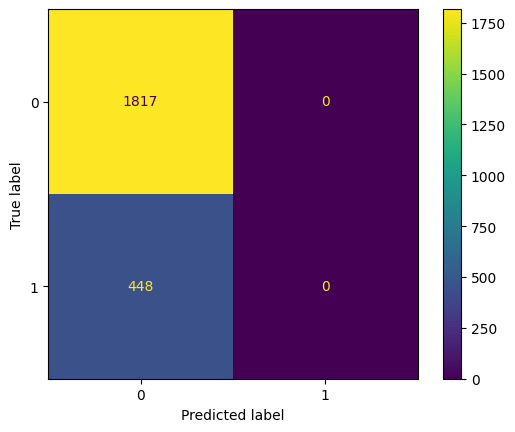

NB, total: Counter({'No': 7248, 'Yes': 1812})
over, rand, 0.125 and under, rand, 0.25
Accuracy: 0.6534216335540839 F1-score: 0.50721908349027
Recall: 0.9017857142857143 Precision: 0.35283842794759823
[[1076  741]
 [  44  404]] 



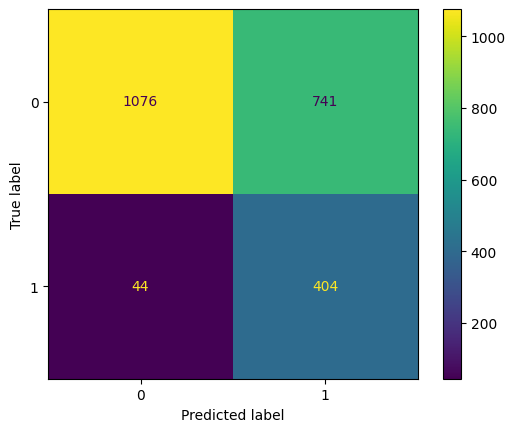

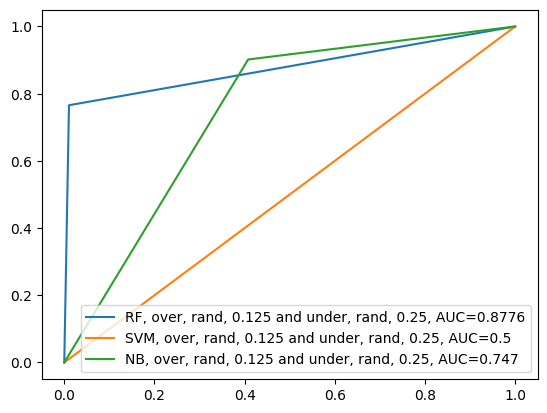

RF, total: Counter({'No': 7248, 'Yes': 3624})
over, rand, 0.25 and under, rand, 0.5
Accuracy: 0.9643119941133186 F1-score: 0.9464384318056323
Recall: 0.9586129753914989 Precision: 0.9345692475463467
[[1764   60]
 [  37  857]] 



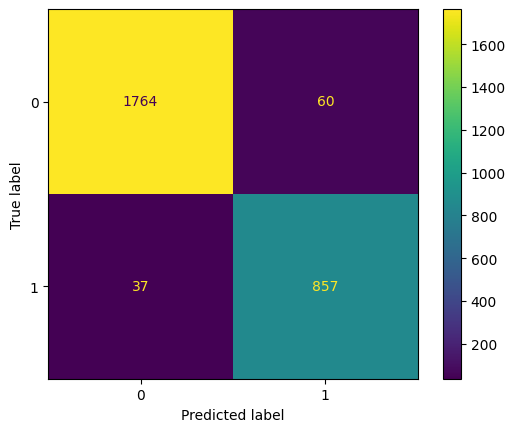

SVM, total: Counter({'No': 7248, 'Yes': 3624})
over, rand, 0.25 and under, rand, 0.5
Accuracy: 0.7236938925680647 F1-score: 0.5500299580587178
Recall: 0.5134228187919463 Precision: 0.5922580645161291
[[1508  316]
 [ 435  459]] 



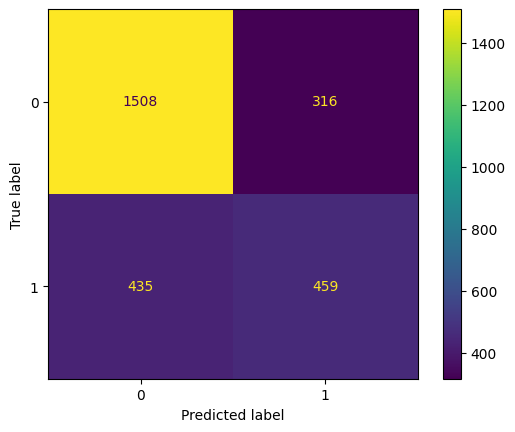

NB, total: Counter({'No': 7248, 'Yes': 3624})
over, rand, 0.25 and under, rand, 0.5
Accuracy: 0.6880058866813834 F1-score: 0.6588897827835881
Recall: 0.9161073825503355 Precision: 0.5144472361809045
[[1051  773]
 [  75  819]] 



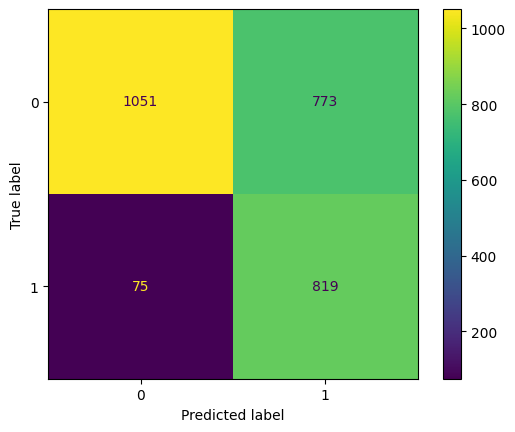



RF, total: Counter({'No': 7248, 'Yes': 5436})
over, rand, 0.375 and under, rand, 0.75
Accuracy: 0.9741406496373384 F1-score: 0.9701383831026948
Recall: 0.9910714285714286 Precision: 0.9500713266761769
[[1757   70]
 [  12 1332]] 



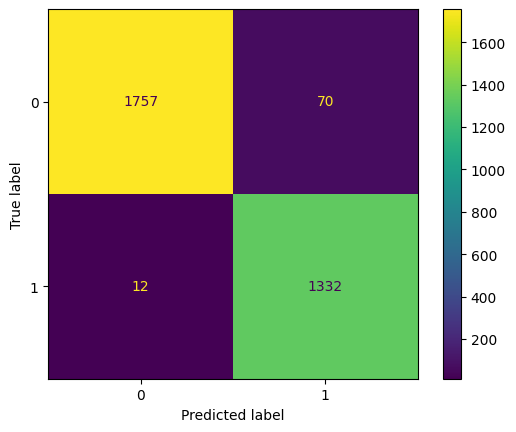

SVM, total: Counter({'No': 7248, 'Yes': 5436})
over, rand, 0.375 and under, rand, 0.75
Accuracy: 0.7215389467045096 F1-score: 0.7342762563948241
Recall: 0.9077380952380952 Precision: 0.6164729661445174
[[1068  759]
 [ 124 1220]] 



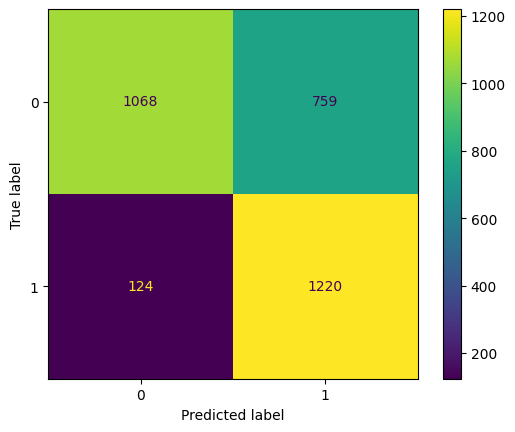

NB, total: Counter({'No': 7248, 'Yes': 5436})
over, rand, 0.375 and under, rand, 0.75
Accuracy: 0.7177546515294859 F1-score: 0.729198184568835
Recall: 0.8965773809523809 Precision: 0.6144824069352371
[[1071  756]
 [ 139 1205]] 



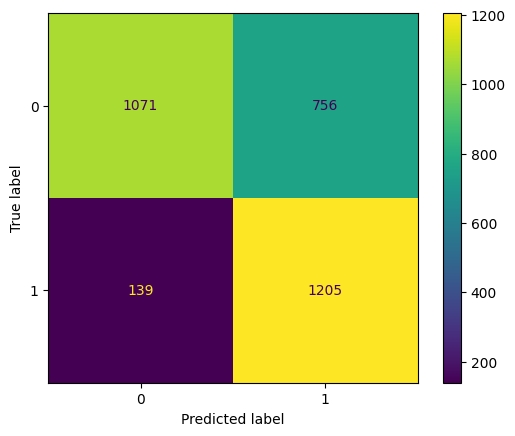



RF, total: Counter({'No': 14496, 'Yes': 14496})
over, smote, 0.25
Accuracy: 0.9695088300220751 F1-score: 0.9694962042788129
Recall: 0.9527943570265871 Precision: 0.9867940432705816
[[3515   47]
 [ 174 3512]] 



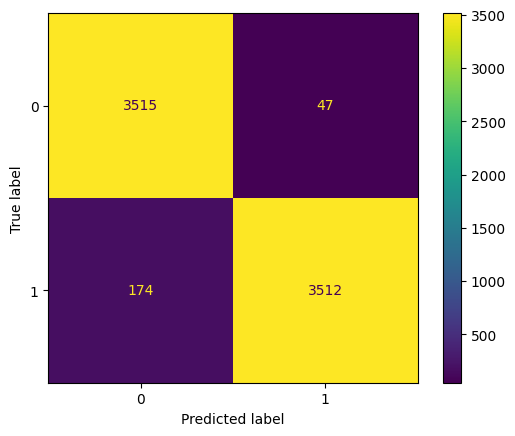

SVM, total: Counter({'No': 14496, 'Yes': 14496})
over, smote, 0.25
Accuracy: 0.8882450331125827 F1-score: 0.8843848130174137
Recall: 0.8404774823657081 Precision: 0.9331325301204819
[[3340  222]
 [ 588 3098]] 



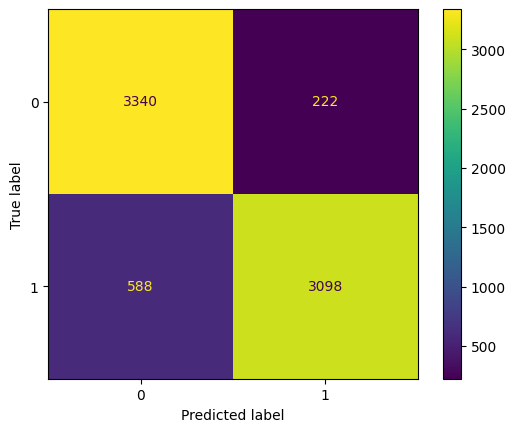

NB, total: Counter({'No': 14496, 'Yes': 14496})
over, smote, 0.25
Accuracy: 0.709575055187638 F1-score: 0.7735828761966226
Recall: 0.9755832881172002 Precision: 0.6408839779005525
[[1547 2015]
 [  90 3596]] 



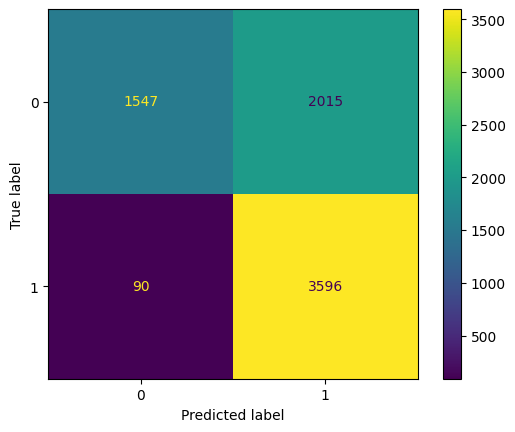

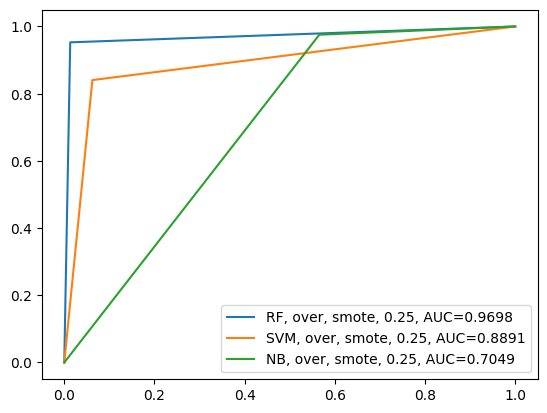

RF, total: Counter({'No': 14496, 'Yes': 14496})
over, smote, 0.5
Accuracy: 0.972682119205298 F1-score: 0.9731051344743277
Recall: 0.9618689581095596 Precision: 0.9846069268829027
[[3468   56]
 [ 142 3582]] 



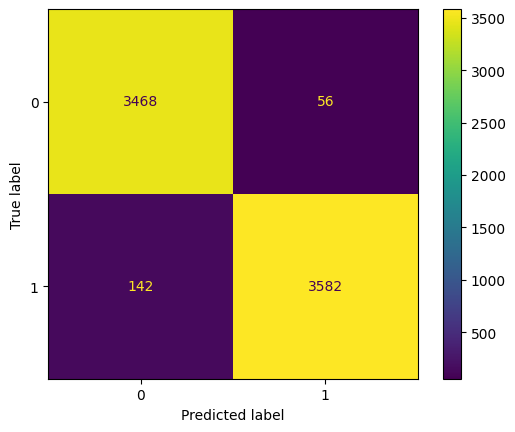

SVM, total: Counter({'No': 14496, 'Yes': 14496})
over, smote, 0.5
Accuracy: 0.8912803532008831 F1-score: 0.8879408418657566
Recall: 0.8383458646616542 Precision: 0.9437726723095526
[[3338  186]
 [ 602 3122]] 



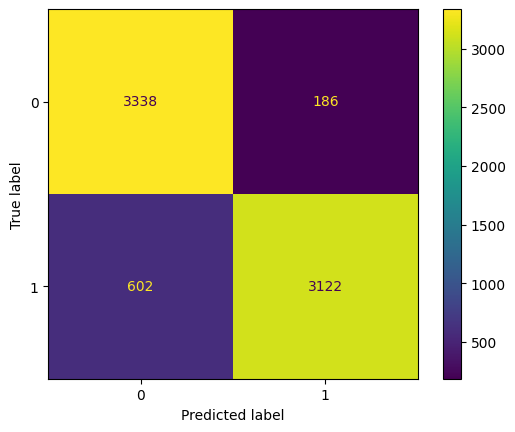

NB, total: Counter({'No': 14496, 'Yes': 14496})
over, smote, 0.5
Accuracy: 0.7179911699779249 F1-score: 0.7802623091808213
Recall: 0.9744897959183674 Precision: 0.65059160989602
[[1575 1949]
 [  95 3629]] 



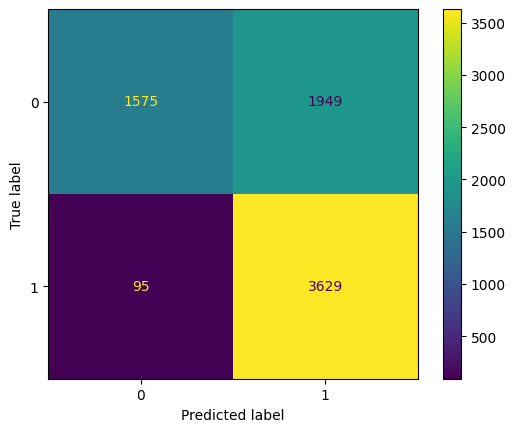



RF, total: Counter({'No': 14496, 'Yes': 14496})
over, smote, 0.75
Accuracy: 0.9724061810154525 F1-score: 0.9724517906336089
Recall: 0.9566395663956639 Precision: 0.988795518207283
[[3518   40]
 [ 160 3530]] 



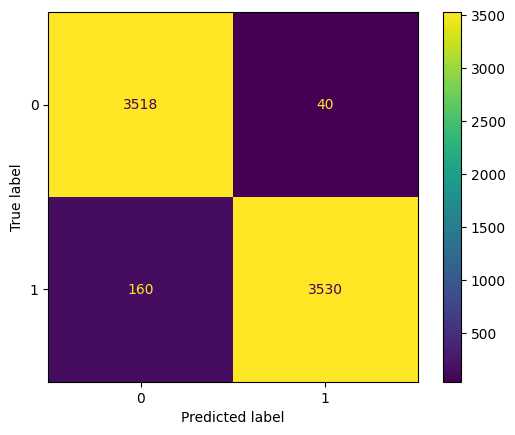

SVM, total: Counter({'No': 14496, 'Yes': 14496})
over, smote, 0.75
Accuracy: 0.8977649006622517 F1-score: 0.8940671908506077
Recall: 0.8474254742547426 Precision: 0.946142208774584
[[3380  178]
 [ 563 3127]] 



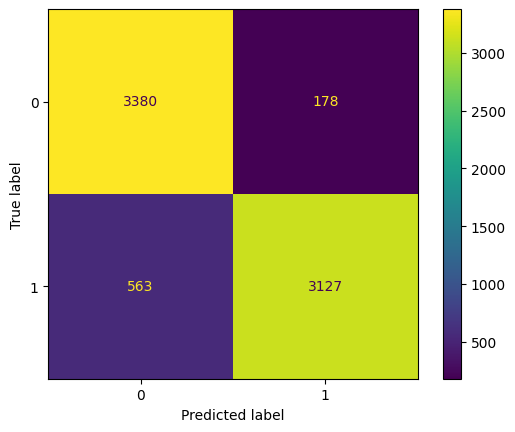

NB, total: Counter({'No': 14496, 'Yes': 14496})
over, smote, 0.75
Accuracy: 0.7166114790286976 F1-score: 0.7771750922108918
Recall: 0.9707317073170731 Precision: 0.6479739507959479
[[1612 1946]
 [ 108 3582]] 



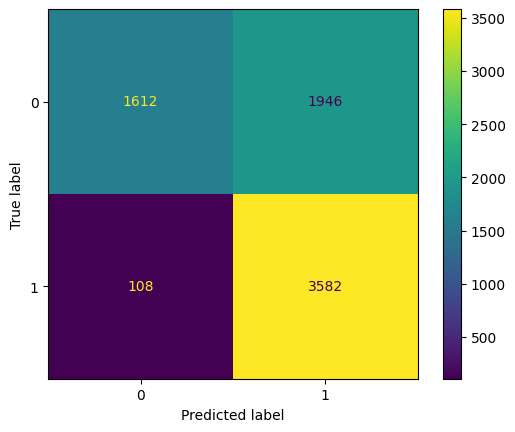



RF, total: Counter({'No': 14155, 'Yes': 923})
tomek, majority
Accuracy: 0.9387267904509283 F1-score: 0.04149377593360996
Recall: 0.02127659574468085 Precision: 0.8333333333333334
[[3534    1]
 [ 230    5]] 



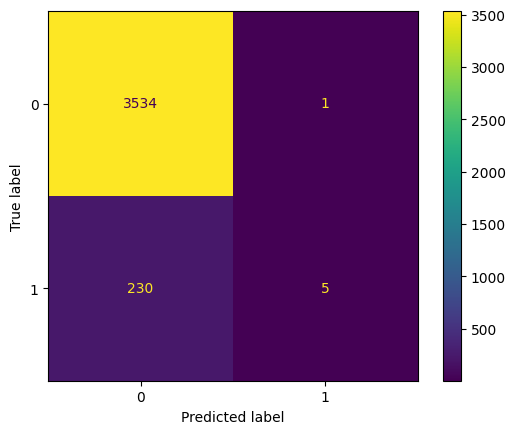

SVM, total: Counter({'No': 14155, 'Yes': 923})
tomek, majority
Accuracy: 0.9376657824933687 F1-score: 0.0
Recall: 0.0 Precision: 1.0
[[3535    0]
 [ 235    0]] 



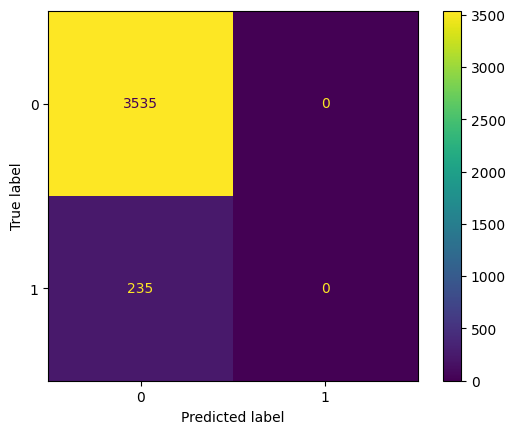

NB, total: Counter({'No': 14155, 'Yes': 923})
tomek, majority
Accuracy: 0.6190981432360743 F1-score: 0.22961373390557935
Recall: 0.9106382978723404 Precision: 0.13136893799877225
[[2120 1415]
 [  21  214]] 



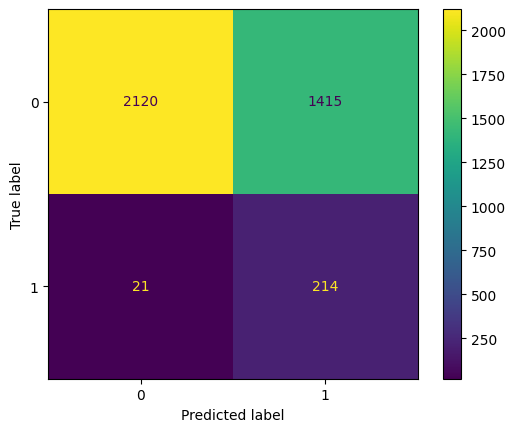

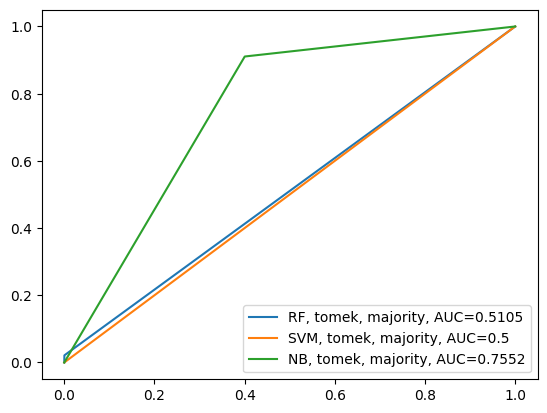

In [ ]:
base =[[X,y]]
yX_datasets_list = [base, overRand_datasets_lol, underRand_datasets_lol, combRand_datasets_lol, overSMOTE_datasets_lol, underTomek_datasets_lol]
sampleInfo_list = ['base',
                   'over, rand, 0.25', 'over, rand, 0.5', 'over, rand, 0.75', 
                   'under, rand, 0.25', 'under, rand, 0.5', 'under, rand, 0.75',
                   'over, rand, 0.125 and under, rand, 0.25', 'over, rand, 0.25 and under, rand, 0.5', 'over, rand, 0.375 and under, rand, 0.75',
                   'over, smote, 0.25', 'over, smote, 0.5', 'over, smote, 0.75', 
                   'tomek, majority'
                   ]
sampleInfo_list.reverse()

for datasets in yX_datasets_list:

  y_pred_list, y_title_list = [], []

  for pair in datasets:
    #print(len(pair))
    X, y = pair
    x_train, x_test, y_train, y_test = train_test_split(X, y) # https://realpython.com/train-test-split-python-data/
    #print(x_train.head(), y_train.head())
    sampleInfo = sampleInfo_list.pop()
    counter = str(Counter(y))

    # Random Forests
    y_pred = randForestModel(x_train, x_test, y_train, y_test)#; print(y_pred)
    #plot_roc_auc(y_test, y_pred, title='RF, '+ sampleInfo)
    acc, prec, rec, f1, cm = evaluateModel(y_test, y_pred, modelInfo= 'RF, total: '+counter+ '\n'+ sampleInfo)
    
    y_pred_list.append(y_pred); y_title_list.append('RF, '+ sampleInfo)
    
    # linear SVMs
    y_pred = svmModel(x_train, x_test, y_train, y_test)
    #plot_roc_auc(y_test, y_pred, title='SVM, '+ sampleInfo)
    acc, prec, rec, f1, cm = evaluateModel(y_test, y_pred, modelInfo= 'SVM, total: '+counter+ '\n'+ sampleInfo)
    y_pred_list.append(y_pred); y_title_list.append('SVM, '+ sampleInfo)

    # Naive Bayes
    y_pred = naiveBayesModel(x_train, x_test, y_train, y_test)
    #plot_roc_auc(y_test, y_pred, title='NB, '+ sampleInfo)
    acc, prec, rec, f1, cm = evaluateModel(y_test, y_pred, modelInfo= 'NB, total: '+counter+ '\n'+ sampleInfo)
    y_pred_list.append(y_pred); y_title_list.append('NB, '+ sampleInfo)
    
    print('\n')
    try:
      plot_multi_roc_auc(y_test, y_pred_list, y_title_list)
    except:
      continue

    

Το dataset αφορά ένα πρόβλημα ασφαλείας αυτοκινήτων.  Με άλλα λόγια, οι αλγόριθμοι -που θα χρησιμοποιηθούν- καλούνται να αντιμετωπίσουν ένα  πρόβλημα κατηγοριοποίησης, αναφορικά με τη διάπραξη ή όχι απάτης  σε περίπτωση  αυτοκινητιστικού  δυστυχήματος. Επομένως, στον Confusion Matrix ιδιαίτερη σημασία θα έχει το πλήθος των False Negative και False Positive  και κατ’ επέκταση οι μετρικές recall και precision.  Οι μετρικές αυτές, συχνά, “λειτουργούν” ανταγωνιστικά μεταξύ τους, εξαιτίας του γνωστού trade-off. Ιδανικά επιθυμάται η υψηλή τιμή και των δύο.  Η αποτύπωση του ιδανικού αποτελέσματος εκφράζεται με μία υψηλή τιμή της μετρικής F1. Η τελευταία συνιστά τον αρμονικό μέσο των δύο προαναφερθέντων.


Στο αρχικό dataset παρατηρείται ότι και τα τρία μοντέλα με εξαίρεση το ΝΒ σημειώνουν υψηλό accuracy, ωστόσο οι υπόλοιπες μετρικές είναι ιδιαίτερα χαμηλές και ειδικά το F1 score. Ενδιαφέρον παρουσιάζει ότι ο ΝΒ έχει  το καλύτερο F1 score συγκριτικά με τα  άλλα δύο.

Στην περίπτωση της τυχαίας υπερδειγματοληψίας, με αναλογία  minority  class/ majority class 0,25,  τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy όσο και την F1   έχει  το RF.

Στην περίπτωση της τυχαίας υπερδειγματοληψίας, με αναλογία  minority  class/ majority class 0,5,  τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy όσο και την F1   έχει  το RF.

Στην περίπτωση της τυχαίας υπερδειγματοληψίας, με αναλογία  minority  class/ majority class 0,75,  τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy όσο και την F1   έχει  το RF.

Γενικά, διαπιστώνεται ότι με την αύξηση της αναλογίας  minority  class/ majority class Δεν βελτιώνεται μόνο η επίδοση του RF,  αλλά και των άλλων δύο μοντέλων. Παρόλα αυτά, το RF κατέχει σταθερά τα πρωτεία.


Στην περίπτωση της τυχαίας υποδειγματοληψίας, με αναλογία  minority  class/ majority class 0,25,  τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy έχει  το RF. Αντίθετα, όσο και σε ό,τι αφορά την μετρική την F1, την έχει ο ΝΒ.

Στην περίπτωση της τυχαίας υποδειγματοληψίας, με αναλογία  minority  class/ majority class 0,5,  τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy έχει  το RF. Αντίθετα, όσο και σε ό,τι αφορά την μετρική την F1, την έχει ο ΝΒ. Η διαφορά των δύο ταξινομητών, ωστόσο, και  στο accuracy και στην F1, δεν είναι ιδιαίτερα μεγάλη.

Στην περίπτωση της τυχαίας υποδειγματοληψίας, με αναλογία  minority  class/ majority class 0,75,  το RF και ο ΝΒ έχουν σχεδόν την ίδια επίδοση σε ό,τι αφορά την μετρική accuracy. Εντούτοις ο ΝΒ φαίνεται να υπερτερεί στην F1.

Το μοντέλο SVM δεν συναγωνίζεται το RF και το ΝΒ, σε καμία από τις παραπάνω περιπτώσεις.


Στην περίπτωση της τυχαίας υπερδειγματοληψίας, με αναλογία minority class/majority class = 0,125 και ακολούθως τυχαίας υποδειγματοληψίας, με αναλογία minority class/majority class = 0,25, τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy όσο και την F1   έχει  το RF.

Στην περίπτωση της τυχαίας υπερδειγματοληψίας, με αναλογία minority class/majority class = 0,25 και ακολούθως τυχαίας υποδειγματοληψίας, με αναλογία minority class/majority class = 0,5, τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy όσο και την F1   έχει  το RF.


Στην περίπτωση της τυχαίας υπερδειγματοληψίας, με αναλογία minority class/majority class = 0,375 και ακολούθως τυχαίας υποδειγματοληψίας, με αναλογία minority class/majority class = 0,75 τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy όσο και την F1   έχει  το RF.


Γενικά το SVM τα πήγε καλύτερα από το NB τόσο ως προς τη μετρική accuracy όσο και ως προς τη μετρική F1, με εξαίρεση την περίπτωση αναλογιών 0,125 και 0,25 στην οποία και σημείωσε μηδενικό F1 score. Παρατηρείται πως τα μοντέλα βελτιώνονται, καθώς αυξάνονται οι αναλογίες.


Στην περίπτωση της υπερδειγματοληψίας με borderline  SMOTE (κατασκευή συνθετικών δεδομένων), με αναλογία minority class/majority class = 0,25, τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy όσο και την F1   έχει  το RF.

Στην περίπτωση της υπερδειγματοληψίας με borderline  SMOTE (κατασκευή συνθετικών δεδομένων), με αναλογία minority class/majority class = 0,5, τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy όσο και την F1   έχει  το RF.

Στην περίπτωση της υπερδειγματοληψίας με borderline  SMOTE (κατασκευή συνθετικών δεδομένων), με αναλογία minority class/majority class = 0,75, τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy όσο και την F1   έχει  το RF.

Αξίζει να σημειωθεί ότι και τα τρία μοντέλα φαίνεται να παρουσιάζουν συλλογικά καλύτερες επιδόσεις συγκριτικά με  όλες τις περιπτώσεις των τυχαίων δειγματοληψιών. Επιπρόσθετα, οι διαφορές μεταξύ τους δεν είναι τόσο μεγάλες όσο στις περιπτώσεις των τυχαίων δειγματοληψιών. Τέλος, το εκάστοτε μοντέλο δεν δείχνει να παρουσιάζει σημαντική βελτίωση, με την αύξηση των αναλογιών στη δειγματοληψία. 

Στην περίπτωση της υποδειγματοληψίας, με καθαρισμό δεδομένων, με τη μεθοδο Tomek links και στρατηγική majority, ,  τη βέλτιστη επίδοση τόσο σε ό,τι αφορά την μετρική accuracy έχει  το RF. Αντίθετα, όσο και σε ό,τι αφορά την μετρική την F1, την έχει ο ΝΒ. To SVM σημείωσε μηδενικό F1 score.

Συμπερασματικά:

Οι καλύτερες επιδόσεις των μοντέλων εμφανίστηκαν στα δεδομένα που προέκυψαν από την εφαρμογή της τεχνικής SMOTE και ακολούθως από την τεχνική της συνδυαστικής τυχαίας υπερδειγματοληψίας και υποδειγματοληψίας. Σε αυτές τις περιπτώσεις τα πρωτεία είχαν τα RFs.

Στην περίπτωση είτε της τυχαίας υποδειγματοληψίας είτε της υποδειγματοληψίας με την τεχνική Tomek links, ο ΝΒ αποδείχθηκε ο πιο ανθεκτικός.

 Τα SVM δεν λειτούργησαν καλά συγκριτικά με τους άλλους δύο ταξινομητές.
